# **Project - Recommendation Systems: Movie Recommendation System**
---------------
**By: Ferdio Nathaniel Priatmodjo**

## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp



Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this proejct.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
# Installing surprise library, only do it for first time
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 122 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633724 sha256=3d05ab917eeeec841989c43b62fcb9c96dc2116bdda1008e44dcbcf30b970e82
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [4]:
# Import the dataset
rating = pd.read_csv('/content/drive/MyDrive/dataset/ratings.csv')

Let's check the **info** of the data

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [6]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## 1. Exploring the dataset 

Let's explore the dataset and answer some basic data-related questions:

In [7]:
# Printing the top 5 rows of the dataset Hint: use .head()
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### Describe the distribution of ratings. 



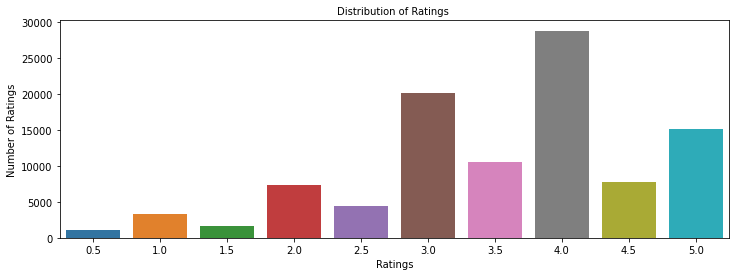

In [8]:
plt.figure(figsize = (12, 4))
sns.countplot(x = rating.rating)
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Observations:**

1. Rating **"4"** is the highest in the number count of rating with approximately **28k ratings**.
2. Rating **"3"** is the second highest in the number count of rating with approximately **20k ratings**.
3. Rating **0.5** is the least in the number count of rating with approximately **1k ratings**
4. Users tend to rate a movie in a round rating (1.0 , 2.0 ,3.0... etc) rather than half rating (1.5 , 2.5 , 3.5, .. etc)

### What is the total number of unique users and unique movies?


In [9]:
# Finding number of unique users
rating['userId'].nunique()

671

In [10]:
# Finding number of unique movies
rating['movieId'].nunique()

9066

**Write your answer here:**

1. There are **671 unique users** in the dataset
2. There are **9066 unique movies** in the dataset
3. There is a possibility of **approximately +- 6 Million ratings** in the dataset. But in our dataset we only have **100k ratings**. It means that not every user has rated every Movie in the dataset. Hence, we can build a recommendation system to recommend movie to users which they have not interacted with.

### Is there any movie that has been interacted with more than once by the same user? 

In [11]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [12]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

**Observation:**

1. The sum is equal to the total number of observations which implies that there is only interaction between a pair of movie and a user.

### Which is the most interacted movie in the dataset?

In [13]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

**Observation:**

1. The most watched (most interacted) movie is the movie with movie Id : **"356"**

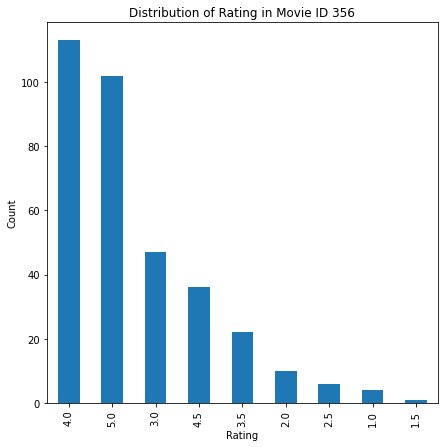

In [14]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')
plt.title("Distribution of Rating in Movie ID 356")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Observations:**

1. We can see that the most watched movie (movieID 356) is **liked by many users**, because of the count of ratings **4 and 5** is higher than any other ratings.

### Which user interacted the most with any movie in the dataset? 

In [15]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**Observation:**

1. The user with **user_id: 547** has interacted with the most number of Restaurant i.e. **2391 times**

### What is the distribution of the user-movie interactions in this dataset?

In [16]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

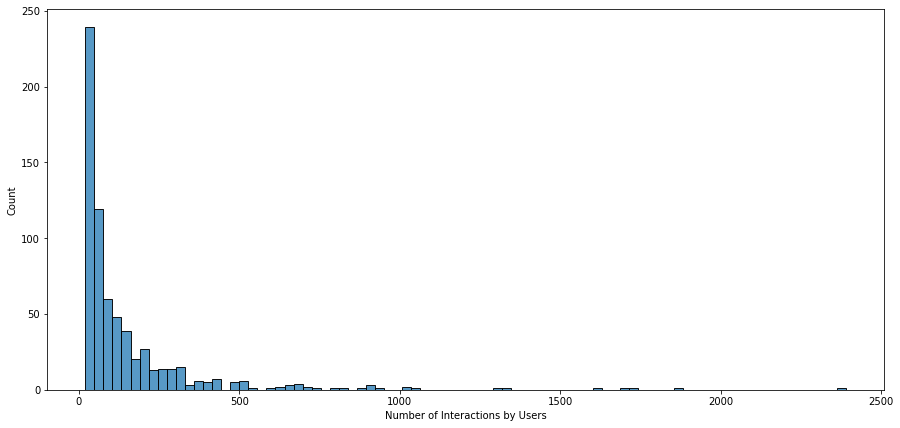

In [17]:
# Plotting user-movie interactions distribution
plt.figure(figsize=(15,7))
sns.histplot(count_interactions)
plt.xlabel('Number of Interactions by Users')
plt.show()

**Observations:**

1. We can see that The Number of Interactions by Users is **highly right skewed**
2. Only few users interacted with more than 250 movies

#### As we have now explored the data, let's start building Recommendation systems

## 2. Create Rank-Based Recommendation System 

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [18]:
# Calculating average ratings
average_rating = rating.groupby('movieId').mean()["rating"]

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()["rating"]

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [19]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [20]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [21]:
list(top_n_movies(final_rating,5,50))

[858, 318, 913, 1221, 50]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [22]:
list(top_n_movies(final_rating,5,100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [23]:
list(top_n_movies(final_rating,5,200))

[318, 50, 527, 608, 296]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## Model 2: User based Collaborative Filtering Recommendation System 

![collaborative_filtering.PNG](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/collaborative_filtering.PNG)

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Building Similarity/Neighborhood based Collaborative Filtering**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/cosine.PNG)

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`**. Finally splitting the data into train and test set.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [25]:
sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options = sim_options , verbose = False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### What is the RMSE for baseline user based collaborative filtering recommendation system?

**Observation:**

1. This baseline user based model has **`RMSE=0.9925`**. We can still improve this using GridSearchCV for optimization. 

### What is the Predicted  rating for an user with userId=4 and for movieId=10 and movieId=3? 

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [26]:
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Observations:**

1. As we can see the predicted/estimated value for user_id "4" with movie_id "10" is **3.62**, slightly different from the actual value by **0.38**

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [27]:
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Observation:**

1. As we can see the estimated rating for this user-item pair is **3.20** based on this similarity user based baseline model

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

### Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system?

In [28]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}


# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9641862836622962
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [29]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.963487,0.962345,0.966726,0.964186,0.001856,1,0.740334,0.739839,0.742256,0.740810,0.001042,1,0.443476,0.064556,6.731165,0.248756,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.991545,0.992342,0.995832,0.993239,0.001862,13,0.766093,0.768027,0.769059,0.767726,0.001229,12,2.066424,0.191006,9.026484,2.111496,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.968865,0.966303,0.970538,0.968569,0.001742,4,0.745088,0.742059,0.745872,0.744340,0.001644,3,0.463238,0.020481,6.239783,0.427651,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.995621,0.994711,0.998085,0.996139,0.001425,15,0.769795,0.769040,0.771256,0.770030,0.000920,15,0.815779,0.114815,3.368629,0.129030,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.973504,0.972293,0.976332,0.974043,0.001692,7,0.748799,0.746902,0.750368,0.748690,0.001417,6,0.189850,0.031053,3.248894,0.163524,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [30]:
sim_options = {
    'name' : 'msd',
    'user_based' : True
}

# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options = sim_options,k= 20, min_k= 3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9571


0.9571445417153293

**Observation:**
1. As we can see above that optimizing the algorithm using GridSearchCV has reduced the RMSE by approximately **0.03** i.e from **0.9925 to 0.9571**

### What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering?

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [31]:
similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

**Observation:**

1. As we can see with the optimized user based algorithm, the predicted/estimated value for user_id "4" with movie_id "10" is **3.74** rather than 3.62 which is much better and closer to the actual rating 4.00

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [32]:
similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

**Observation:**

1. As we can see with the optimized algorithm, the estimated rating for this user-item pair is **3.72**

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [33]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [34]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [35]:
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

### Predict the top 5 movies for userId=4 with similarity based recommendation system

In [36]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

## **Model 3: Item based Collaborative Filtering Recommendation System (7 Marks)**

In [37]:
# Definfing similarity measure
sim_options = {'name' : 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### What is the RMSE for baseline item based collaborative filtering recommendation system ?

**Observation:**

1. This baseline item based model has **`RMSE=1.0032`**. We can still improve this using GridSearchCV for optimization.



Let's us now predict rating for an user with `userId=4` and for `movieId=10`

### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3?

In [38]:
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**Observation:**

1. As we can see the predicted/estimated value for user_id "4" with movie_id "10" is **4.37**, slightly different from the actual value by 0.37


Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [39]:
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**Observation:**

1. As we can see the estimated rating for this user-item pair is **4.07** based on this similarity item based baseline model


### Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system?

In [40]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9411597620828437
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [41]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.945557,0.956266,0.953349,0.951724,0.004521,7,0.729493,0.738130,0.735809,0.734477,0.003649,7,9.105628,0.827173,12.796300,0.440449,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.008458,1.018527,1.014407,1.013798,0.004133,16,0.784807,0.795106,0.791070,0.790328,0.004237,16,25.051014,0.603711,11.585016,0.118588,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.945370,0.956374,0.953597,0.951780,0.004673,8,0.729507,0.738250,0.736190,0.734649,0.003732,8,8.259318,0.487597,13.065026,0.489364,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.008362,1.018680,1.014705,1.013916,0.004249,17,0.784873,0.795232,0.791412,0.790506,0.004278,17,22.343670,0.411043,13.627179,0.576715,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.945821,0.956474,0.954461,0.952252,0.004621,9,0.730014,0.738373,0.736980,0.735122,0.003657,9,8.279476,0.807471,13.012947,0.532099,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [42]:
sim_options = {
    'name' : 'msd',
    'user_based' : False
}
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options, k=40, min_k=3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

**Observation:**

1. As we can see Optimizing the algorithm using GridSearchCV has reduced the RMSE by approximately **0.06** i.e from 1.0032 to 0.9433

### What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering?

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [43]:
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

**Observation:**

1. As we can see with the optimized item based algorithm, the predicted/estimated value for user_id "4" with movie_id "10" is **4.26** rather than 4.37 which is much better and closer to the actual rating 4.00

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [44]:
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

**Observation:**

1. If we compare the above predicted rating, we can see the baseline model predicted rating as **4.07** and the optimized model predicted the rating as **3.87**.

### **Identifying similar users to a given user (nearest neighbors)**
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [45]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [46]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

### Predict the top 5 movies for userId=4 with similarity based recommendation system

In [47]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD (7 Marks)**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

Now if we notice the above movies closely:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF4.PNG)

Here **Action**, **Romance**, **Suspense** and **Comedy** are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF5.PNG)



### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

First we need to convert the below movie-rating dataset:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

into an user-item matrix as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF6.PNG)

We have already done this above while computing cosine similarities.

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### **U-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### **Sigma-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### **V-transpose matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

### **Build a baseline matrix factorization recommendation system**

In [48]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9037


0.903693910022341

### What is the RMSE for baseline SVD based collaborative filtering recommendation system?

**Observations:**

1. The RMSE for baseline SVD based model is **0.9037**!!
2. This model is so far has the lowest RMSE i.e the best model for this recommendation problem
3. This SVD model has not been optimized yet. Hence, We can still produce a better RMSE score with the optimized SVD model using GridSearchCV.

### What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3?

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [49]:
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.21   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.213625363337626, details={'was_impossible': False})

**Observation:**

1. Only **0.21** difference between the actual and predicted rating. Clearly this algorithm performs better than the other two collaborative filtering algorithm (user based and item based)

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [50]:
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.57   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.5713053985805976, details={'was_impossible': False})

**Observation:**

1. We can see that estimated rating for this user-item pair is **3.57** based on this matrix factorization based baseline mode

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system?

In [51]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8932353045884108
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [52]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.946785,0.943701,0.938834,0.943106,0.003273,25,0.739065,0.738690,0.736665,0.738140,0.001054,25,5.863122,0.673372,0.701692,0.121846,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.951157,0.947786,0.942911,0.947285,0.003385,26,0.744587,0.743319,0.741831,0.743246,0.001126,26,5.310702,0.149479,0.697690,0.039015,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.956133,0.953820,0.948296,0.952750,0.003288,27,0.749877,0.749699,0.747360,0.748979,0.001147,27,5.033050,0.155121,0.685738,0.070177,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.911845,0.906281,0.900819,0.906315,0.004501,11,0.704348,0.701982,0.699781,0.702037,0.001865,9,5.218200,0.066201,0.712135,0.022414,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.918453,0.913392,0.908035,0.913293,0.004254,15,0.711713,0.709468,0.708235,0.709805,0.001440,15,4.716599,0.033832,0.771323,0.057776,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8952


0.8951750061310431

### What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering?

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [54]:
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9850548413867175, details={'was_impossible': False})

**Observation:**

1. As we can see with the optimized SVD model, we obtain a predicted value of **3.99** (only 0.01 difference from the actual rating!!). This is much more better if we compare to all previous algorithm.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [55]:
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.63   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.634862082894409, details={'was_impossible': False})

### Predict the top 5 movies for userId=4 with SVD based recommendation system?

In [56]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(1192, 4.99150748077781),
 (3310, 4.953780675681377),
 (926, 4.9536684652725365),
 (5114, 4.931994616288283),
 (116, 4.930593229694299)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [57]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

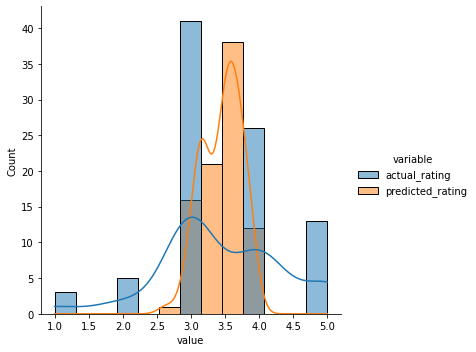

In [58]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**Observations:**

This comparison graph is for **item based optimized algorithm** using GridSearchCV with `RMSE = 0.9411`

1. As we can see, the distribution of predicted ratings is closely following the distribution of actual ratings. Although it is not perfect but it is still good considering many users only rated a few movies. The total bins for predicted ratings are nearly same as to the total bins for actual ratings.
2. We can see that there are more predicted ratings between 3 and 4 this is expected because the actual ratings 3 and 4 have more count than the other ratings and Hence, the predicted values will mostly lie between 3 and 4 and of course they are mostly continuous values.  

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

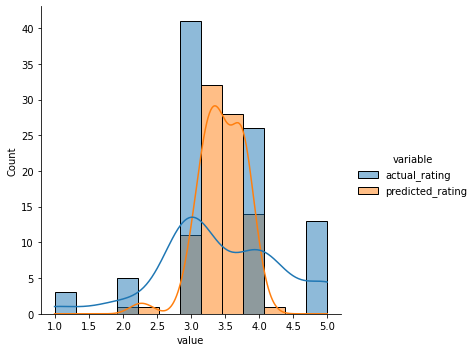

In [59]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [60]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant movies, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

To know more about precision recall in Recommendation systems refer to these links : 

https://surprise.readthedocs.io/en/stable/FAQ.html

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

### Compute the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values? 

In [61]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [64]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.766
-----> Recall:  0.41
> k=5, model=KNNBasic
-----> Precision:  0.773
-----> Recall:  0.419
> k=5, model=KNNBasic
-----> Precision:  0.609
-----> Recall:  0.329
> k=5, model=KNNBasic
-----> Precision:  0.675
-----> Recall:  0.353
> k=5, model=SVD
-----> Precision:  0.752
-----> Recall:  0.382
> k=5, model=SVD
-----> Precision:  0.747
-----> Recall:  0.383
> k=10, model=KNNBasic
-----> Precision:  0.75
-----> Recall:  0.552
> k=10, model=KNNBasic
-----> Precision:  0.752
-----> Recall:  0.559
> k=10, model=KNNBasic
-----> Precision:  0.597
-----> Recall:  0.477
> k=10, model=KNNBasic
-----> Precision:  0.658
-----> Recall:  0.503
> k=10, model=SVD
-----> Precision:  0.735
-----> Recall:  0.515
> k=10, model=SVD
-----> Precision:  0.729
-----> Recall:  0.522


**Observations:**

1. Collaborative Filtering using user-user based interaction performed well in both the k values with Precision value ~76% (k=5) and with ~75% (k=10).

**7.1 Compare the results from the base line user-user and item-item based models.**

**7.2 How do these baseline models compare to each other with respect to the tuned user-user and item-item models?**

**7.3 The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE and precision recall for the models.**

**7.4 Does it improve? Can you offer any reasoning as to why that might be?**

**Answers :**

**We know that the main metrics for this problem is precision so we shall improve and focus more on the precision rather than the recall**
******************************************************************************
**7.1** User based and Item based baseline Collaborative model have nearly the same performance. User based has value `RMSE = 0.9925` while Item based has slightly different value with `RMSE = 1.0032`.
*******************************************************************************
**7.2** If we compare the based baseline model and the tuned model we can see a huge difference in RMSE. user based has difference `diff user RMSE = |0.9925-0.9641| = 0.0284` and for item based the difference is `diff item RMSE = |1.0032 - 0.9433| = 0.0599`. When comparing these two tuned algorithms using GridSearchCV, tuned item based has performed better with `RMSE = 0.9433` compared to tuned user based with `RMSE = 0.9641`. **Overall the tuned algorithms have performed better than those untuned model.**
*******************************************************************************
**7.3** Collaborative Filtering searches for neighbors based on similarity of item (example) preferences and recommend items that those neighbors interacted while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices. 

Suppose that **we want to compared the user based baseline collaborative model with based SVD Matrix Factorization model**, **We can see a huge difference between them. user based baseline model has `RMSE = 0.9925` while based SVD model has `RMSE=0.9037`** that is almost **0.1 difference in RMSE**. Of course it is a huge difference because if you compare the user based baseline model with item based baseline model or maybe with the tuned one the difference is not more than 0.06 ( < 0.06 ). 

But **there are not much precision and recall difference between the collaborative filtering model and the matrix factorization model** as you can see suppose that we use k=10 the SVD model has precision around **0.73** while user based model has **0.75** also for the recall **0.552** and **0.522** for user based and svd respectively. 
*******************************************************************************
**7.4** If you want to compare between based SVD model and tuned SVD model, Tuning SVD matrix factorization model is not improving the base line SVD much.
As we can see the RMSE difference between them `RMSE based SVD = 0.9037` and `RMSE tuned SVD = 0.8952` it is less than 0.01 difference (<0.01)

Matrix Factorization has lower RMSE due to the reason that it assumes that both items and users are present in some low dimensional space describing their properties and recommend a item based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

### **Conclusions**

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.